**Author:** John Shing Chau Leung

**Description:** A program to extract information and implement data quality cuts for Gaia (DR2) data. The program receives input as the raw Gaia data in FITS format. It then condenses the data and implement a pre-defined set of cuts on the stellar kinematic data quality. 2MASS data is used for computing completeness in the bright luminosity region of the main sequence stars. For this purpose, the "*gaiaSelect*" function is needed (available in my jo_bovy folder), which a modified "*tgasSelect*" function in Jo Bovy's *gaia_tools* available publicly online. The output is passed to *exclusion_plot.ipynb* for further model-likelihood analysis.

**date:** 10-10-2018

## Library and Initalization

Define your search path for Bovy's libraries.

In [1]:
import sys
sys.path.insert(0, "/Users/john/Desktop/bovy_code/mwdust-master")
sys.path.insert(0, "/Users/john/Desktop/bovy_code/gaia_tools-master")
sys.path.insert(0, "/Users/john/Desktop/bovy_code/tgas-completeness-master/py")
sys.path.insert(0, "/Users/john/Desktop/bovy_code/isodist-master")

%env GAIA_TOOLS_DATA=/Users/john/Desktop/bovy_code/gaia_tools-master
%env DUST_DIR=/Users/john/Desktop/bovy_code/mwdust-master

env: GAIA_TOOLS_DATA=/Users/john/Desktop/bovy_code/gaia_tools-master
env: DUST_DIR=/Users/john/Desktop/bovy_code/mwdust-master


The first few blocks import all the libraries. I receive **RunTimeError** messages from running *import numpy* concerning the version compatibility, but the program still runs anyways so I neglected it. There might also be *warning* message concerning Jo Bovy's *effsel.py*, which should not affect the code's running.

The middle block contains just the variables Jo Bovy used to select tracer stars. Except for "*max_plx_error*", it is specific to Schutz's analysis to control the statistical behavior for the parallax uncertainty.

The last two blocks Jovy Bovy's functions for the proper evfs generation.

In [2]:
import os
import pylab
import numpy as np
import healpy

import matplotlib.pyplot as plt
from astropy import units
from astropy.coordinates import SkyCoord
from astropy.coordinates import GeocentricTrueEcliptic
from astropy.coordinates import ICRS
from astropy.coordinates import Galactic
from galpy.util import bovy_plot, bovy_coords, save_pickles, multi
from galpy.util.bovy_coords import cov_pmrapmdec_to_pmllpmbb
from matplotlib import cm

import tqdm
from scipy import interpolate, optimize, integrate
import mwdust
import effsel
from isodist import Z2FEH, imf, PadovaIsochrone
import gaia_tools.load, gaia_tools.select
from gaia_tools import xmatch
from effsel import main_sequence_cut_r, giant_sequence_cut

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
plt.style.use("seaborn-bright")
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10
plt.rc('text', usetex=True)

min_plx= 0.2/0.2
max_dist = 1./min_plx
tsf_jmin= 0.
max_plx_error = 0.4

def cyl_vol_func(X,Y,Z,xymin=0.,xymax=0.25,zmin=0.05,zmax=0.15):
    """A function that bins in cylindrical annuli around the Sun"""
    xy = np.sqrt(X**2.+Y**2.)
    out = np.zeros_like(X)
    out[(xy >= xymin)*(xy < xymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out

def is_good_relplx(mj):
    out= np.empty_like(mj)
    out[mj > 5.] = 20.
    out[mj < 0.] = 10.
    out[(mj >= 0)*(mj <= 5.)] = 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

/Users/john/Desktop/bovy_code/tgas-completeness-master/py/effsel.py:32: RuntimeWarning: invalid value encountered in less_equal
  sp_indx*= (numpy.roll((sp['JH']+sp['HK']),1)-(sp['JH']+sp['HK'])) <= 0.



Standard initialization for the color spectrum, gaia data loading and absolute luminosity calculation. Color description using Johnson's **B-V** is possible but will not be implemented in this notebook. (Due to the heavy use of G stars)

In [3]:
sp = effsel.load_spectral_types()
gaia = gaia_tools.load.gaia(dr=2)

bv = np.empty_like(gaia['j_mag'])
jk = gaia['j_mag']-gaia['k_mag']
dm = -5.*np.log10(gaia['parallax'])+10.
mj = gaia['j_mag']-dm

indx_jk_nan = np.isfinite(jk)
gaia = gaia[indx_jk_nan]
jk = jk[indx_jk_nan]
dm = dm[indx_jk_nan]
mj = mj[indx_jk_nan]
bv = bv[indx_jk_nan]

tsf= gaia_tools.select.gaiaSelect( max_plxerr=max_plx_error, min_lat=0.)

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/gaiaSelect.py:154: RuntimeWarning: invalid value encountered in greater
  *(self._ext_jt < jmax+djt/2.)*(self._ext_jt > jmin-djt/2.) # John: cutting the set j, jk space boundary

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/gaiaSelect.py:154: RuntimeWarning: invalid value encountered in less
  *(self._ext_jt < jmax+djt/2.)*(self._ext_jt > jmin-djt/2.) # John: cutting the set j, jk space boundary

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/gaiaSelect.py:228: RuntimeWarning: invalid value encountered in divide
  *(True-numpy.isnan((nstargaia/nstar2mass)[:,ii])) # John: cutting the region to calculate completeness and cutting out nan

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/gaiaSelect.py:232: RuntimeWarning: invalid value encountered in divide
  nstar_ratio = (nstargaia/(nstar2mass))[spl_indx,ii]

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools

## Data cut flow of star density

We introduce our cut flow modules.

*cut_flow* : A function to streamline a list of cuts in the variable *cuts*. It takes a data array in the argument and return a length-reduced data with the cuts implemented. Arguments:
    - data - np.array. Input data array.
    - cuts - a list of boolean arrays. Each boolean array specifies which entries in *data* are to be removed.
    
Then we introduce our first cut. The *cut_general*,

*cut_general* : Return a single-elemented boolean cut array list. It select the "good" statistics entries from the gaia data set. The return value is to be used by the *cut_flow* function.

All future (more complicated) cuts will follow this programming flow.

In [5]:
def cut_flow(data, cuts):
   for i, cut_indx in enumerate(cuts):
      data = data[cut_indx]
   return data

def cut_general(gaia):
   stat_indx = tsf.determine_statistical(gaia,gaia['j_mag'],gaia['k_mag'])
   gaia=gaia[stat_indx]
   return [stat_indx]

init_cuts = cut_general(gaia)

gaia = cut_flow(gaia, init_cuts)
bv= cut_flow(bv, init_cuts)
jk= cut_flow(jk, init_cuts)
dm= cut_flow(dm, init_cuts)
mj= cut_flow(mj, init_cuts)

print( 'gaia entry count: ', len(gaia) ) 

('gaia entry count: ', 23524357)


Velocity matching

A cylindrical cut which cuts away stars with r > r_cyl_cut and |z| > z_cyl_cut in a cylindrical volume. Introducing a completeness volume early on will save computation time in the upcoming steps.

In [6]:
r_cyl_cut = 0.15 
z_cyl_cut = 0.25 

parallax_sys_offset = 0.03

def cut_indx_vol(gaia, rcut, zcut):
   XYZ= bovy_coords.lbd_to_XYZ(gaia['l'],gaia['b'],1./gaia['parallax'],degree=True)
   r_cyl = np.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.)
   z_cyl= XYZ[:,2]
   return  [(r_cyl < r_cyl_cut)*(np.abs(z_cyl) < z_cyl_cut)]

vol_cut_indx = cut_indx_vol(gaia, r_cyl_cut, z_cyl_cut)
bv_cyl = cut_flow(bv, vol_cut_indx)
jk_cyl = cut_flow(jk, vol_cut_indx)
mj_cyl = cut_flow(mj, vol_cut_indx)
gaia_cyl = cut_flow(gaia, vol_cut_indx)

gaia['parallax'] = gaia['parallax'] + parallax_sys_offset

print( 'Vol-reduced gaia entry count: ', len(gaia_cyl) )

('Vol-reduced gaia entry count: ', 835676)


Plotting the sky density map

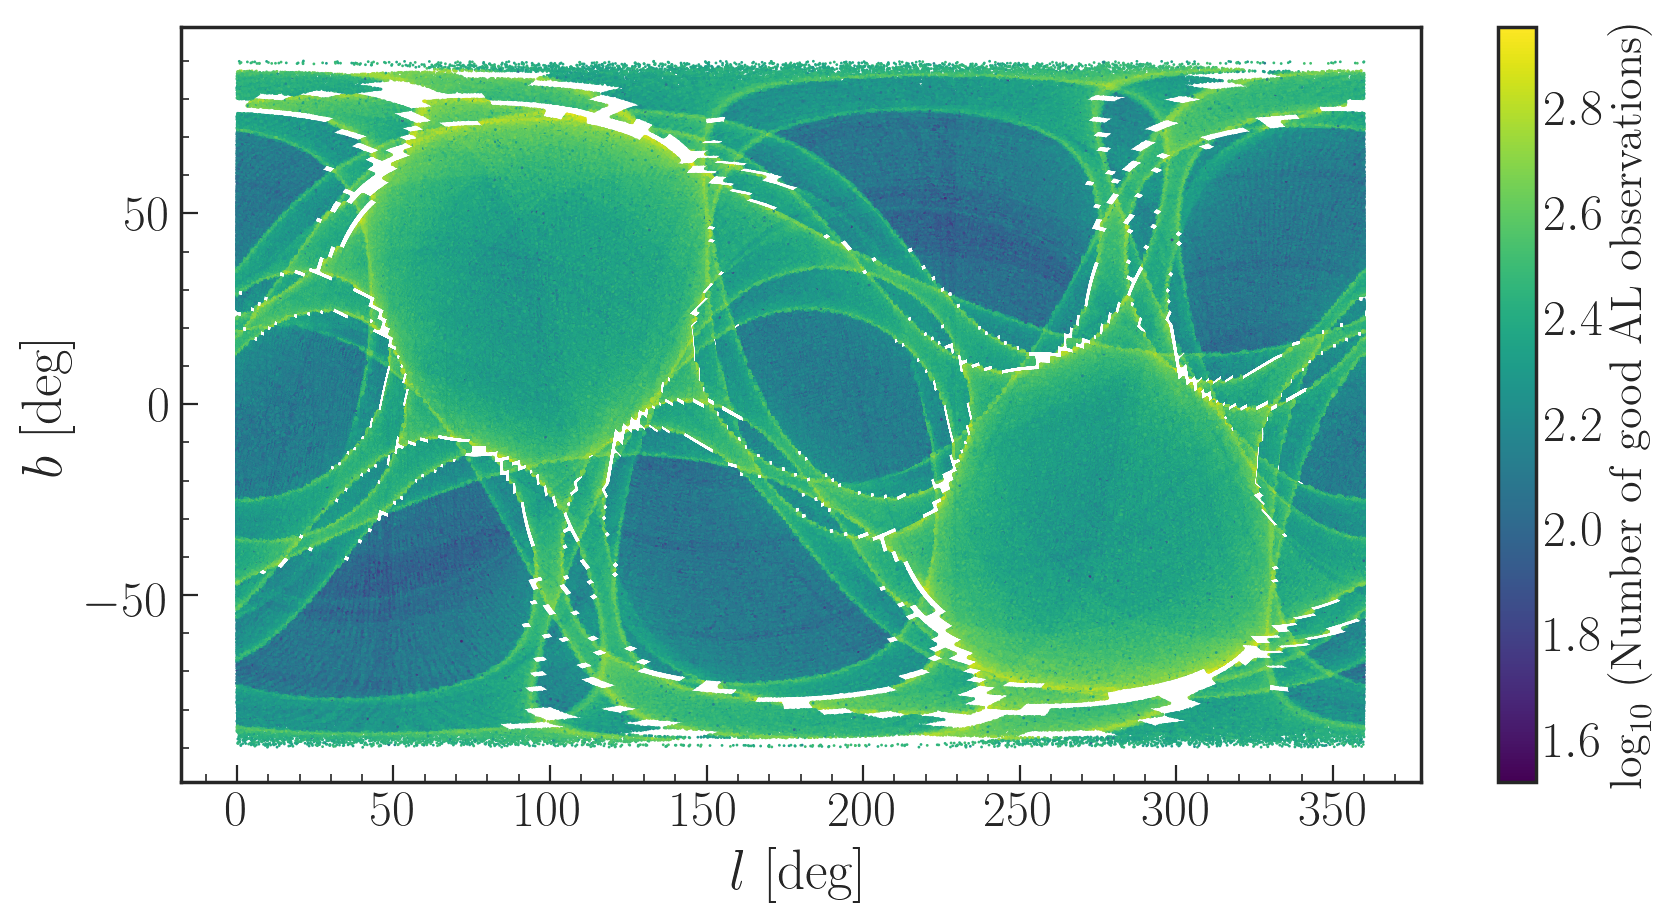

In [7]:
cos= SkyCoord(gaia['ra'],gaia['dec'],unit="deg")
cos= cos.transform_to(GeocentricTrueEcliptic)
elats= cos.lat.to('deg').value
elon= cos.lon.to('deg').value

plt.figure(figsize=(10,5))
plt.style.use("seaborn-bright")
plt.minorticks_on();
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=16)

plt.scatter(gaia['l'], gaia['b'], c=np.log10(gaia['astrometric_n_good_obs_al']), s=1, cmap='viridis', edgecolor='')
plt.xlabel(r'$l \ \rm{[deg]}$', size = 20); plt.ylabel(r'$b \ \rm{[deg]}$', size = 20);
cbar = plt.colorbar(); cbar.set_label(r'$\rm{log}_{10}\ (\rm{Number\ of\ good\ AL\ observations})$', size = 16)
cbar.ax.tick_params(labelsize=18)
plt.savefig('skymap.png', dpi=200);plt.show()

Plotting the sky-map for different variables

/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10



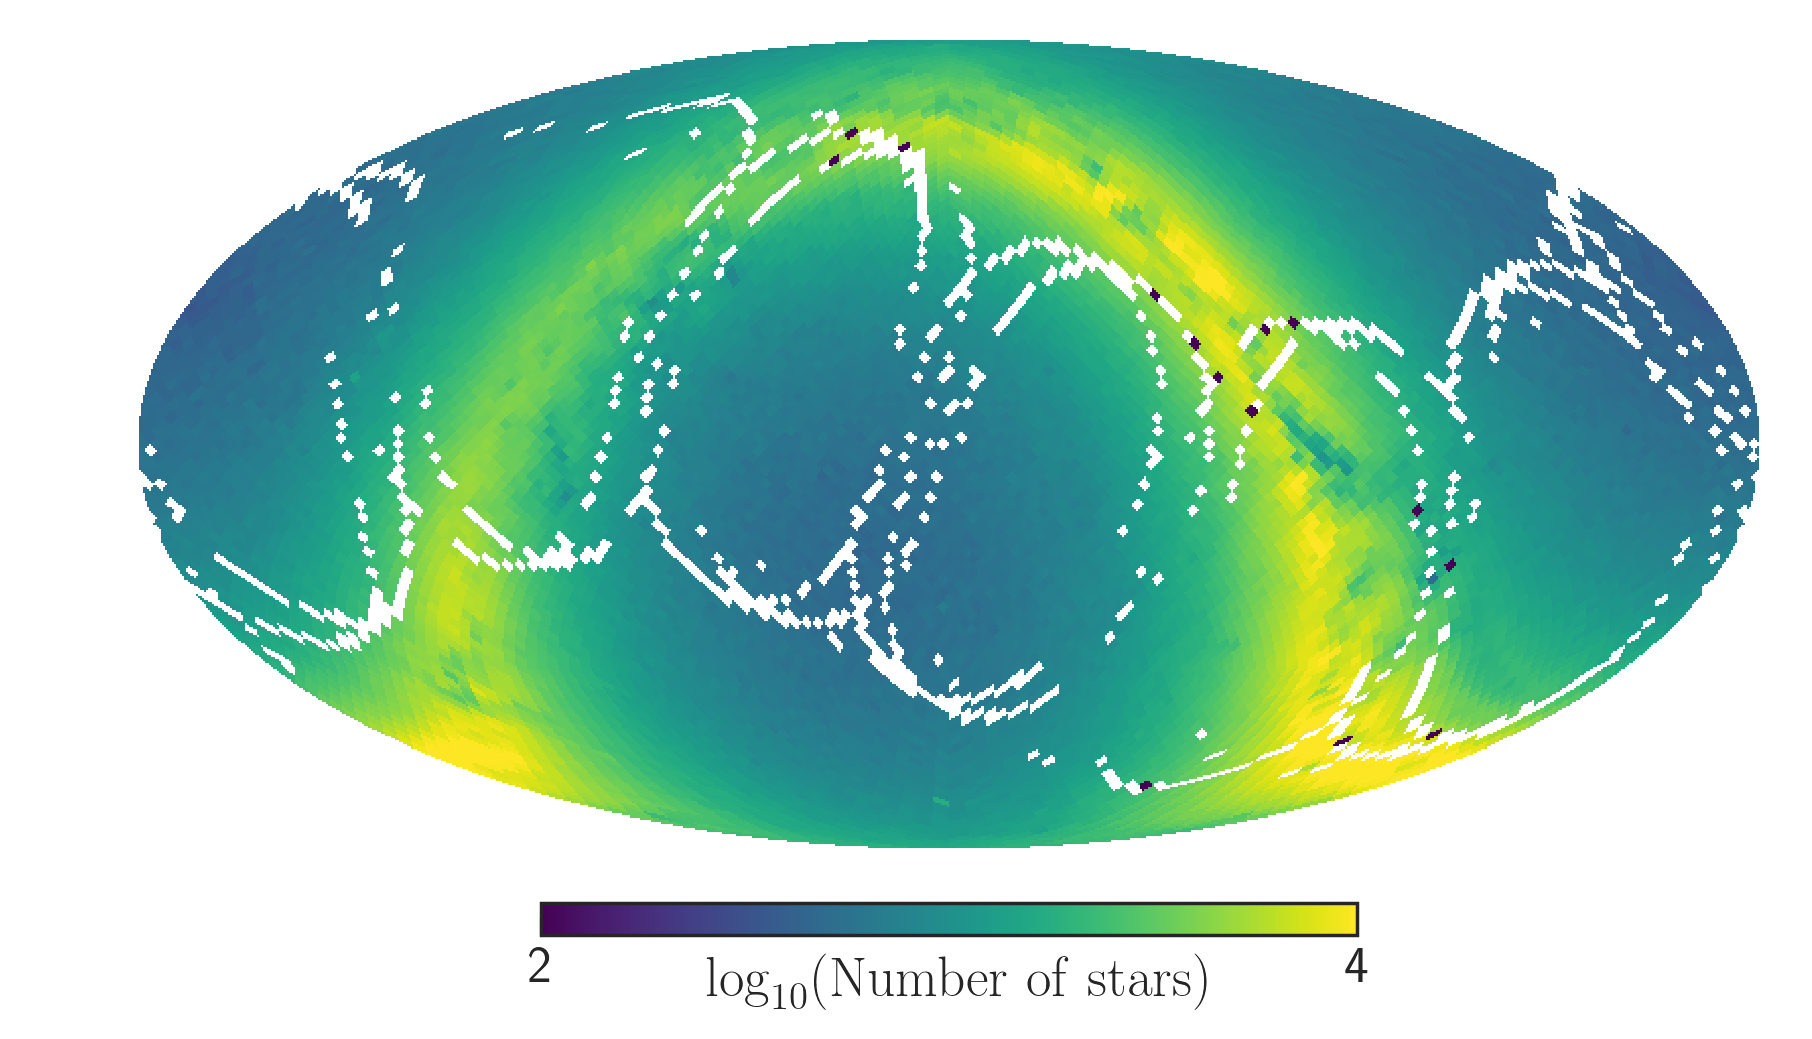

/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide

/Users/john/anaconda2/lib/python2.7/site-packages/healpy-1.11.0-py2.7-macosx-10.6-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)

/Users/john/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:2301: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))

/Users/john/anaconda2/lib/python2.7/site-packages/healpy-1.11.0-py2.7-macosx-10.6-x86_64.egg/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0

/Users/john/anaconda2/lib/python2.7/site-packages/healpy-1.11.0-py2.7-macosx-10.6-x86_64.egg/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0



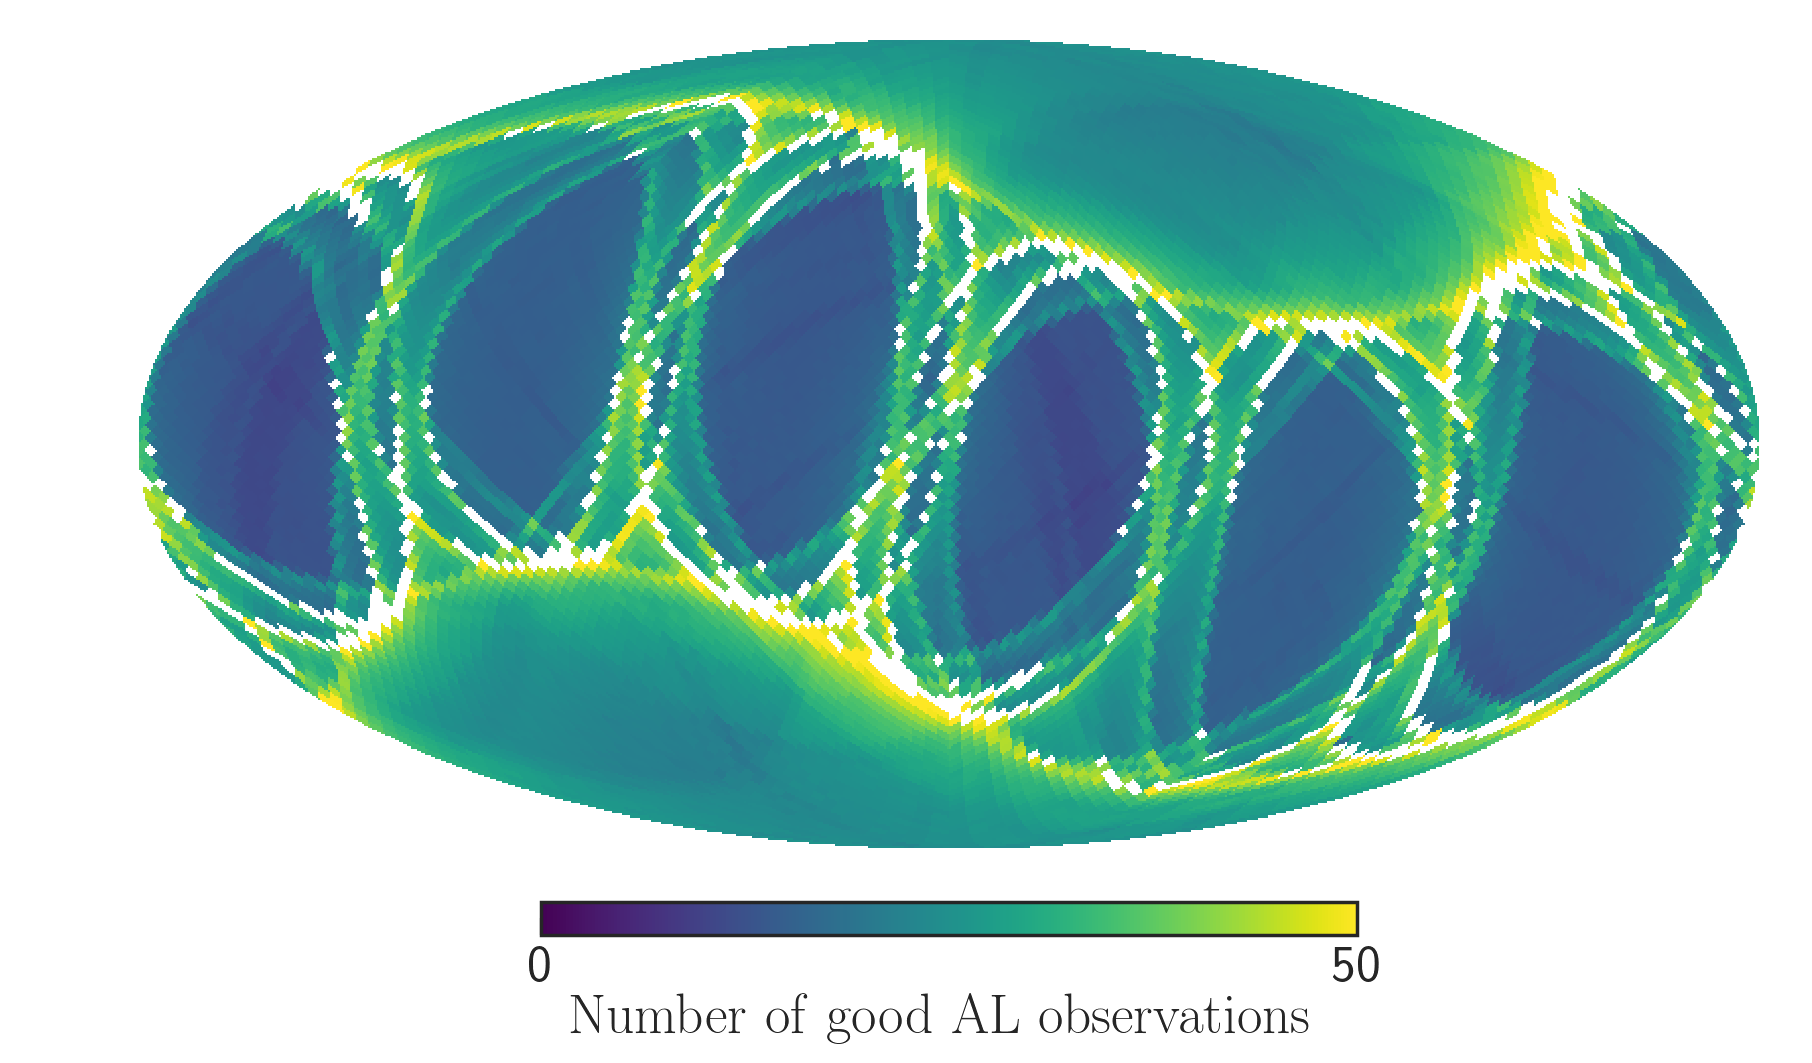

/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide



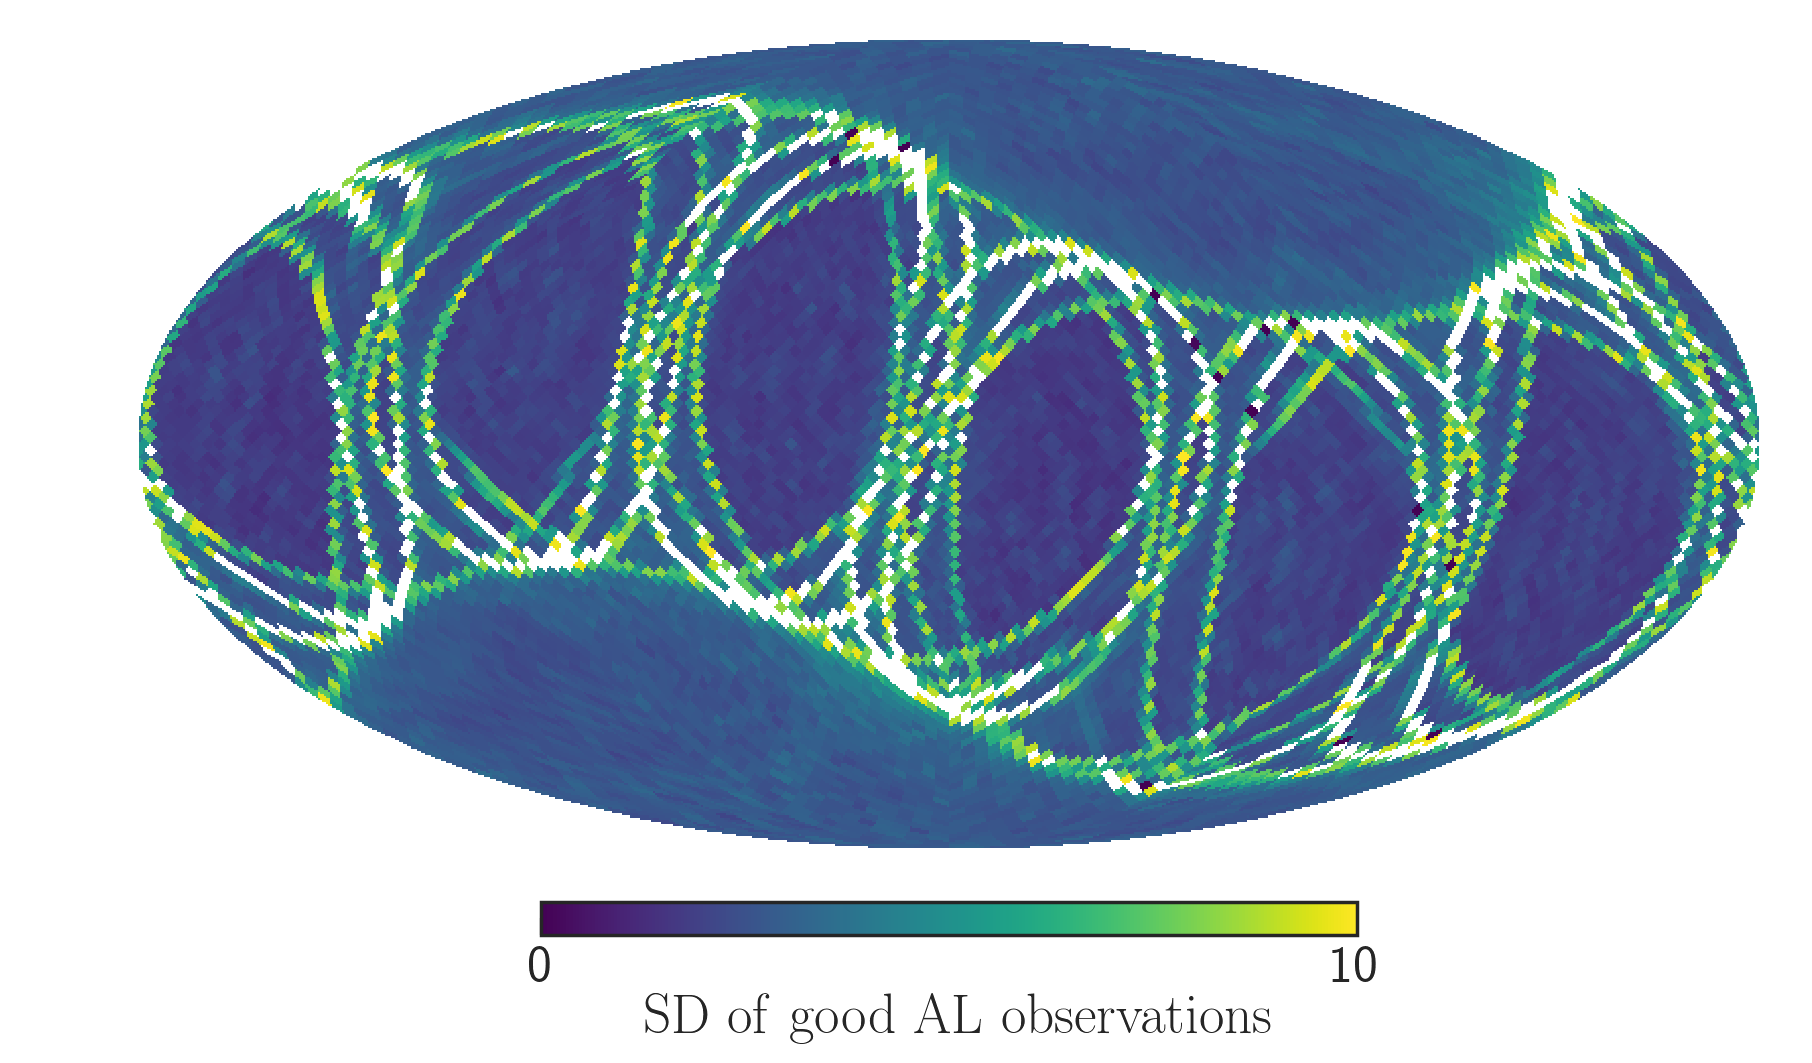

In [8]:
BASE_NSIDE = 2**5

theta= np.pi/180.*(90.- gaia['dec'])
phi= np.pi/180.*gaia['ra']
pix= healpy.ang2pix(BASE_NSIDE,theta,phi,nest=True)

plt.figure(figsize=(5,4))
plt.style.use("seaborn-bright")

nstars, es = np.histogram(pix,range=[-0.5,healpy.nside2npix(BASE_NSIDE)-0.5],bins=healpy.nside2npix(BASE_NSIDE))
nobs, e = np.histogram(pix,range=[-0.5,healpy.nside2npix(BASE_NSIDE)-0.5],bins=healpy.nside2npix(BASE_NSIDE),
                         weights=(gaia['astrometric_n_good_obs_al']/9.))
nvar, e = np.histogram(pix,range=[-0.5,healpy.nside2npix(BASE_NSIDE)-0.5],bins=healpy.nside2npix(BASE_NSIDE),
                         weights=(gaia['astrometric_n_good_obs_al']/9.)**2)
cmap= cm.viridis
cmap.set_under('w')
rcParams.update({'font.size': 19})

healpy.mollview(np.log10(nstars), nest=True,
                cmap=cmap,min=2.,max=4,title="")
plt.text(-0.6, -1.39, r"$\rm{log}_{10}\rm{(Number\ of\ stars)}$", fontsize=20)
plt.savefig('starmap_moll.pdf', dpi=200);plt.show()
plt.clf()
healpy.mollview(nobs/(1.*nstars),nest=True,
                cmap=cmap,min=0.,max=50,title="")
plt.text(-0.935, -1.45, r'$\rm{Number\ of\ good\ AL\ observations}$', fontsize=20)
plt.savefig('skymap_moll.pdf', dpi=200);plt.show()
healpy.mollview(np.sqrt(nvar/(1.*nstars)-(nobs/(1.*nstars))**2),nest=True,
                cmap=cmap,min=0.,max=10,title="")
plt.text(-0.75, -1.45, r'$\rm{SD\ of\ good\ AL\ observations}$', fontsize=20)
plt.savefig('variancemap_moll.pdf', dpi=200);plt.show()

A module for dereddening. It is optional at this moment.

*find_jk_boundaries* : A function to find the color boundaries for a star category. Return a *2-tuple* with the first element being the "upper" boundary (smaller j-k) and the second element the "lower" boundary (larger j-k). Arguments:
    - starCategory - string. The star's (sub-)category.
    - sp - Jo Bovy's effsel spectral class array.

I have defined the color boundaries for each star category to be the midpoints between its own midpoint and the midpoint of the adjacent star categories. Supported classes are
- **All** stars
- **A**, **F**, and **G** which contains only G0V to G4V
- **Letter** + **number** labeled all subcategories, e.g. A0, G5, etc.

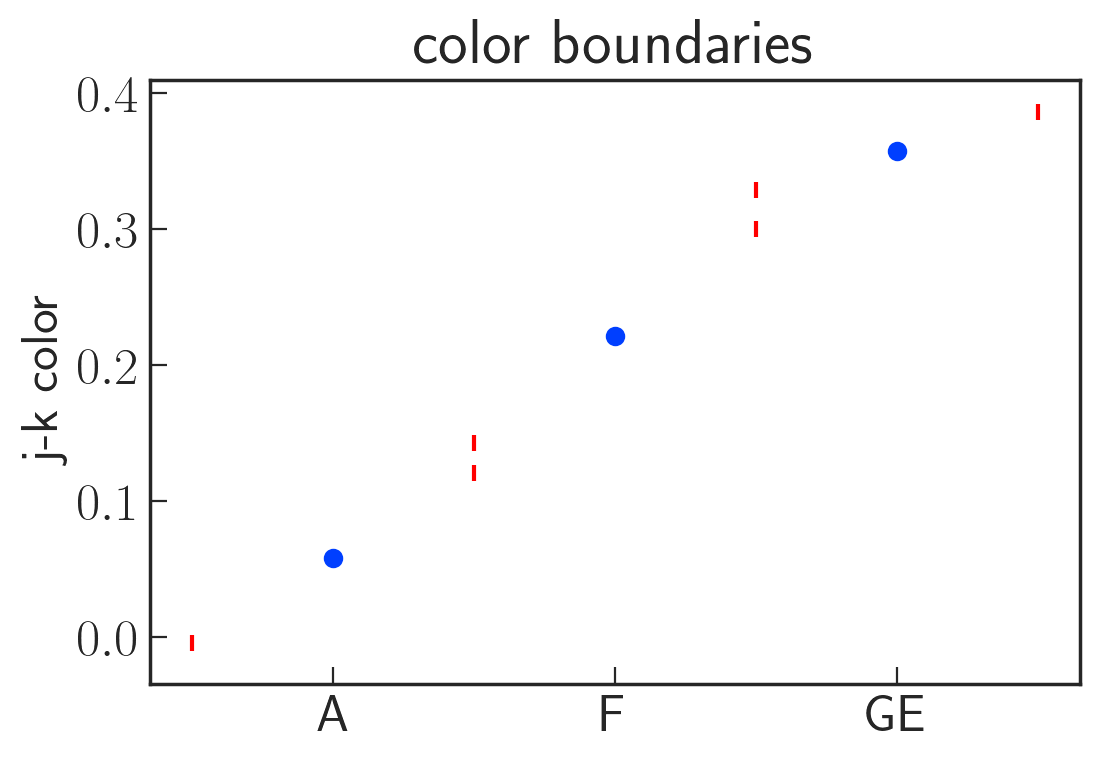

In [9]:
def find_jk_boundaries(starCategory, sp):

   sp_stars = lambda star_Cat: np.array([( str(star_Cat) in s) for s in sp['SpT'] ], dtype='bool')
   jk_color_cut_upper = float("nan")
   jk_color_cut_lower = float("nan")

   # First consider the input as main classes
   if starCategory == "A":
      jk_color_cut_upper =   (sp['JH']+sp['HK'])[ sp_stars('A0V') ] 
      jk_color_cut_lower =   (sp['JH']+sp['HK'])[ sp_stars('A9V') ] 
   elif starCategory == "F":
      jk_color_cut_upper = (sp['JH']+sp['HK'])[ sp_stars('F0V') ] 
      jk_color_cut_lower = (sp['JH']+sp['HK'])[ sp_stars('F9V') ] 
   elif starCategory == "GE": # THIS IS A SHORT-LISTED G CATEGORY
      jk_color_cut_upper = (sp['JH']+sp['HK'])[ sp_stars('G0V') ]
      jk_color_cut_lower = (sp['JH']+sp['HK'])[ sp_stars('G5V') ]
   elif starCategory == "GL": # THIS IS A SHORT-LISTED G CATEGORY
      jk_color_cut_upper = (sp['JH']+sp['HK'])[ sp_stars('G5V') ]
      jk_color_cut_lower = (sp['JH']+sp['HK'])[ sp_stars('G9V') ]
   elif starCategory == "G":
      jk_color_cut_upper = (sp['JH']+sp['HK'])[ sp_stars('G0V') ]
      jk_color_cut_lower = (sp['JH']+sp['HK'])[ sp_stars('G9V') ]
   elif starCategory == "All":
      jk_color_cut_upper = (  (sp['JH']+sp['HK'])[ sp_stars('B9V') ] + (sp['JH']+sp['HK'])[ sp_stars('A0V') ]  )/2
      jk_color_cut_lower = (  (sp['JH']+sp['HK'])[ sp_stars('G4V') ] + (sp['JH']+sp['HK'])[ sp_stars('G5V') ]  )/2 
   elif starCategory == "K":
      jk_color_cut_upper = (  (sp['JH']+sp['HK'])[ sp_stars('G9V') ] + (sp['JH']+sp['HK'])[ sp_stars('K0V') ]  )/2
      jk_color_cut_lower = (  (sp['JH']+sp['HK'])[ sp_stars('K9V') ] + (sp['JH']+sp['HK'])[ sp_stars('M0V') ]  )/2
   elif starCategory == "FU":
      jk_color_cut_upper = (  (sp['JH']+sp['HK'])[ sp_stars('A9V') ] + (sp['JH']+sp['HK'])[ sp_stars('F0V') ]  )/2
      jk_color_cut_lower = (  (sp['JH']+sp['HK'])[ sp_stars('F6V') ] + (sp['JH']+sp['HK'])[ sp_stars('F7V') ]  )/2
   elif starCategory == "FL":
      jk_color_cut_upper = (  (sp['JH']+sp['HK'])[ sp_stars('F7V') ] + (sp['JH']+sp['HK'])[ sp_stars('F6V') ]  )/2
      jk_color_cut_lower = (  (sp['JH']+sp['HK'])[ sp_stars('F9V') ] + (sp['JH']+sp['HK'])[ sp_stars('G0V') ]  )/2
   else : # then consider the input as a subclass or a list of adjacent subclasses
      for list_i, bo_val in enumerate(sp_stars(starCategory)):
         if bo_val == True:
            jk_color_cut_upper = (  (sp['JH']+sp['HK'])[list_i-1] + (sp['JH']+sp['HK'])[list_i]  )/2
      for list_i, bo_val in enumerate( reversed(sp_stars(starCategory)) ):
         if bo_val == True:
            jk_color_cut_lower = (  (sp['JH']+sp['HK'])[len(sp)-list_i] + (sp['JH']+sp['HK'])[len(sp)-list_i-1]  )/2

   return (jk_color_cut_upper, jk_color_cut_lower)

categories_to_be_plotted = ["A","F","GE"] 
categories_boundaries_u = np.array([]); categories_boundaries_l = np.array([]); categories_midpoints = np.array([]);

for i, cat in enumerate(categories_to_be_plotted):
   upper, lower = find_jk_boundaries(cat, sp)
   mid = (upper + lower)/2.
   categories_boundaries_u = np.append(categories_boundaries_u, upper)
   categories_boundaries_l = np.append(categories_boundaries_l, lower)
   categories_midpoints = np.append(categories_midpoints, mid)
plt.scatter(range(len(categories_boundaries_u)), categories_boundaries_u, marker='|',color='red')
plt.scatter(np.array(range(len(categories_boundaries_l)))+1, categories_boundaries_l, marker='|',color='red')
plt.scatter(np.array(range(len(categories_midpoints)))+0.5, categories_midpoints, marker='o')
plt.xticks(np.array(range(len(categories_midpoints)))+0.5,categories_to_be_plotted);plt.ylabel("j-k color"); plt.title("color boundaries");
plt.show()

*generate_evfs* is a function that generate the complete effective volume for a certain class of stars specified by *mj_tight* and *jk_tight*. The return is a 2-tuple with the first element specifying the z-binning in a np.array; the second element specifying the evfs, which one-to-one corresponds to the bins in the first return element.

*load_evfs* do the same thing as *generate_evfs*. But instead of numerical integration, it loads the evfs and the z-binning from a file.

If *to_load_evfs* is used, **make sure the z-spatial grid between this program and the evfs file matches** (both the z-range and z steps).

*cut_evfs* perform cut on the gaia stars so that the *mj* and *jk* after the cut will generate the correct evfs volume when they are passed to the *generate_evfs* function as arguments.

In [10]:
def generate_evfs(mj_tight, jk_tight, spt, zspace, nintt_step = None, filename="default_evfs.txt" , save=True, rv_cut=False):

   zWidth = np.mean( (np.roll(zspace,-1) - zspace)[:-1] )
   evfs = np.array([])

   tesf= gaia_tools.select.gaiaEffectiveSelect(tsf,dmap3d=mwdust.Zero(),MJ=mj_tight,JK=jk_tight,maxd=1.6)#maxd=max_dist)
   if nintt_step == None:
      nintt_step = (2501*('A' in spt) + 1001 * (True-('A' in spt)))
   
   for i, z_i in enumerate(zspace):
      zmin = z_i - zWidth/2.
      zmax = z_i + zWidth/2.
      
      evfs = np.append(evfs, tesf.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=r_cyl_cut,zmin=zmin,zmax=zmax), ndists=nintt_step,xyz=True,relative=True)   )

   if save == True:
      np.savetxt(filename, np.transpose( np.array([zspace, evfs]) ), delimiter=',',header="z_Bin_center, rel_effective_vol", fmt='%10.5f')
      
   return (zspace, evfs)

def load_evfs(filename="default_evfs.txt"):
   ZBINSCOLUMN = 0
   EVFSCOLUMN = 1
   zBins, evfs = np.genfromtxt(filename, delimiter= ",", usecols=(ZBINSCOLUMN, EVFSCOLUMN), unpack=True, skip_header=1)
   return (zBins, evfs)

def cut_evfs(starCat, sp, jk, mj, gaia, cut_bright=False):
   tightness = False
   cut_indx = []

   jk_color_cut_upper, jk_color_cut_lower = find_jk_boundaries(starCat, sp)

   color_cut =  (jk > jk_color_cut_upper)*(jk < jk_color_cut_lower)\
    *(gaia['parallax']/gaia['parallax_error'] > (is_good_relplx(mj)))\
    *(jk != 0.)

   jk_tight = jk[color_cut]
   mj_tight = mj[color_cut]

   if False:
      good_mj_cut_tight = [True for k in range(mj_tight)]
   else:
      good_mj_cut_tight = (mj_tight > main_sequence_cut_r(jk_tight,tight=tightness))\
        *(mj_tight < main_sequence_cut_r(jk_tight,low=True,tight=tightness))
   if cut_bright:
      tjk= np.median(jk[good_mj_cut_tight])
      tjmin= 8.
      tsf._jmin= tjmin
   else:
      tsf._jmin= 2.

   return [color_cut, good_mj_cut_tight]

Perform the evfs color-magnitude cut and generate the evfs.

('Star Category: ', 'A')
('star count after cut ', 225643)
('Star Category: ', 'F')
('star count after cut ', 2106935)
('Star Category: ', 'GE')
('star count after cut ', 2825293)


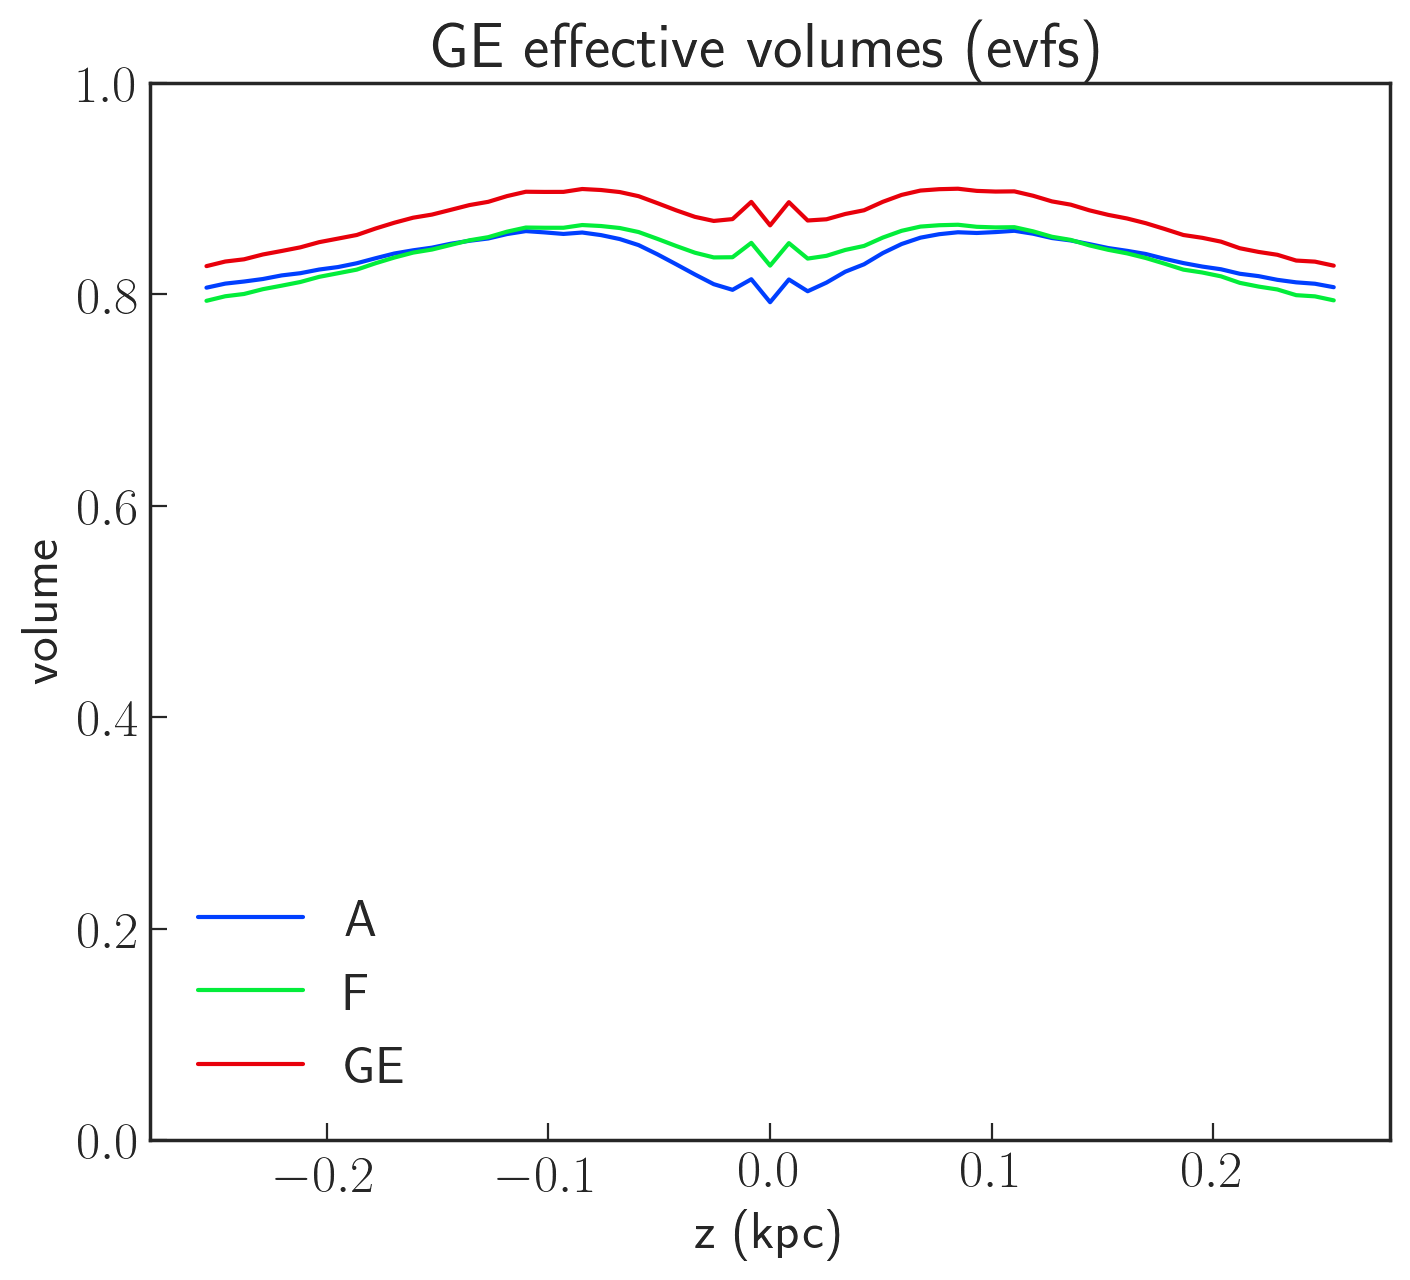

In [11]:
star_Cats = ['A','F','GE']

plt.figure(figsize=(8,7))
plt.ylim(0.0, 1.0)

for star_Cat in star_Cats:
   zNBin_evfs = 60

   file_evfs = "evfs_" + star_Cat + "_jk40.txt"
   to_load_evfs = False
   to_save_evfs = False

   zRangeList = []
   evfs_out = []
 
   data_list = []
   err_list = []
   binz_list = []

   print("Star Category: ", star_Cat)
   zStepWidth = 2*z_cyl_cut/(zNBin_evfs-1)
   zspace_evfs = np.linspace(-z_cyl_cut-zStepWidth/2., z_cyl_cut+zStepWidth/2., zNBin_evfs+1)

   evfs_cuts = cut_evfs(star_Cat, sp, jk, mj, gaia)
   mj_evfs = cut_flow(mj, evfs_cuts)
   jk_evfs = cut_flow(jk, evfs_cuts)
   _ , evfs_out = generate_evfs(mj_evfs, jk_evfs, star_Cat, zspace = zspace_evfs, filename=file_evfs, save=to_save_evfs)

   if to_save_evfs:
      data = np.transpose( np.array([zspace_evfs, evfs_out]) )
      line_header = "# z (pc), evfs"
      np.savetxt(file_evfs, data, delimiter=',',header=line_header)

    
   plt.plot(zspace_evfs, evfs_out, label=star_Cat)
   plt.ylabel("volume"); plt.xlabel("z (kpc)"); plt.title(star_Cat + " effective volumes (evfs)")
   print( 'star count after cut ', len(mj_evfs) ) 


plt.legend(); plt.show()

Generate the proper motion from the ICRS coordiates (RA, Dec) to the galactic coordiates ( l, b ), which we will use to calculate the radial velocity.

In [12]:
def cut_stars(starCat, sp, jk, mj, gaia): # category cut and volume cut
   tightness = False
   cut_indx = []

   jk_color_cut_upper, jk_color_cut_lower = find_jk_boundaries(starCat, sp)
   color_cut =  (jk > jk_color_cut_upper)*(jk < jk_color_cut_lower)*(gaia['parallax'] > min_plx)*(jk != 0.)\
    *( mj > main_sequence_cut_r(jk,tight=tightness))*(mj < main_sequence_cut_r(jk,low=True,tight=tightness))\
    *(gaia['parallax'] > min_plx)*(jk != 0.)

   return [color_cut]

def ProperMotionTransform(ra_coord, dec_coord, pmra_coord, pmdec_coord):
   pmra_coord_cosdec = pmra_coord
   icrs = ICRS(ra=ra_coord*units.degree, dec=dec_coord*units.degree, pm_ra_cosdec=pmra_coord_cosdec*units.mas/units.yr, pm_dec=pmdec_coord*units.mas/units.yr)
   galactic = icrs.transform_to(Galactic)
   pml = (galactic.pm_l_cosb)/np.cos(galactic.b.radian)/(units.mas/units.yr)
   pmb = galactic.pm_b/(units.mas/units.yr)
   return (pml, pmb)


Further cut the stars so that only the star category specified by the variable *star_Cat* remains. The evfs ( $\Theta_i$ ) previous generated are stored as *evfs_weights* $w_i = \Theta_i^{-1}$, which then will be stored in the output density file to be used to generate the physical star density.

The code behind the commented line-breaker is just for the plots in this ipynb, and does no effect on the calculations that follow.

All the information is output to the star density file (*save_file_density*), which will be the density data to compared with the prediction by the Poisson-Jeans solver.

In [15]:
star_Cats = ['A','F','GE']

evfs_err_list=[]
evfs_list=[]
dz_plt=zStepWidth

zspace_hist_plt = np.linspace( -z_cyl_cut*1000,z_cyl_cut*1000, int(2*z_cyl_cut/dz_plt)+1 )
bins_plt = (zspace_hist_plt + dz_plt/2.)[:-1]

for star_Cat in star_Cats:
   stars_cut = cut_stars(star_Cat, sp, jk_cyl, mj_cyl, gaia_cyl)
    
   stars_categorized = cut_flow(gaia_cyl, stars_cut)
   jk_categorized = cut_flow(jk_cyl, stars_cut)
   mj_categorized = cut_flow(mj_cyl, stars_cut)

   ldeg = stars_categorized['l']
   bdeg = stars_categorized['b']
   plx = stars_categorized['parallax']
   XYZ= bovy_coords.lbd_to_XYZ(ldeg, bdeg, 1./plx, degree=True)
   z_kpc= XYZ[:,2]
   z_pc = XYZ[:,2]*1000.

   zRangeList_upper = zspace_evfs + zStepWidth/2
   zRangeList_lower = zspace_evfs - zStepWidth/2
   evfs_weight = np.array([])
   for i, z_i in enumerate(z_kpc):
      zPosition_indx = (z_i < zRangeList_upper)*(z_i >= zRangeList_lower)
      if np.sum(zPosition_indx) != 1:
          print(("star at z = ", z_i, " kpc has wrong binning!"))
          print("belongs to " + str(np.sum(zPosition_indx)) + " bins")
      evfs_weight = np.append(evfs_weight, 1./evfs_out[zPosition_indx] )

   save_file_density = star_Cat + '_stars.txt'


   radeg = stars_categorized['ra']
   decdeg = stars_categorized['dec']
   pmra = stars_categorized['pmra']
   pmdec = stars_categorized['pmdec']

   pml, pmb = ProperMotionTransform(radeg, decdeg, pmra, pmdec)

   hipID = np.zeros_like(radeg)
   e_plx = stars_categorized['parallax_error']
   err_pml = [0.  for k in range(len(stars_categorized)) ]
   covpm = [0.  for k in range(len(stars_categorized)) ]

   bRad = bdeg*np.pi/180.
   ErrZcoord = np.abs(np.divide(1000.,plx**2)*np.sin(bRad)*e_plx)
   rv_categorized = stars_categorized['radial_velocity']
   rv_err_categorized = stars_categorized['radial_velocity_error']

   data = np.transpose( np.array([hipID,ldeg,bdeg,plx,e_plx,z_pc,evfs_weight, jk_categorized,mj_categorized, \
   mj_categorized,jk_categorized, pml,pmb,err_pml,covpm,covpm,ErrZcoord, rv_categorized, rv_err_categorized]) )

   line_header = "# HpID, l (deg), b (deg), plx (mas), err_plx (mas), z_coord (pc), evfs_w, (B-V), AbsMag, AbsMag Corrected, \
(B-V) Corrected, pm_l (mas/yr), pm_b (mas/yr), err_pml (mas/yr) , err_pmb (mas/yr), cov_pmlpmb, err_z_coord (pc), v_r, err_v_r, evfs_rv"

   np.savetxt(save_file_density, data, delimiter=',',header=line_header)

   print("Data saved to ", save_file_density)
   print( 'star count after cut ', len(stars_categorized) ) 

   stars_plt_evfs, _, _ = plt.hist(z_pc, zspace_hist_plt, weights=evfs_weight)
   stars_plt_evfs_err, _ , _ = plt.hist(z_pc, zspace_hist_plt)
   for i, z_err in enumerate(stars_plt_evfs_err):
      if z_err == 0:
         continue
      else :
         stars_plt_evfs_err[i] = stars_plt_evfs[i]/np.sqrt(z_err)
            
   evfs_list.append(stars_plt_evfs)
   evfs_err_list.append(stars_plt_evfs_err)
   plt.clf()
   


('Data saved to ', 'A_stars.txt')
('star count after cut ', 3458)
('Data saved to ', 'F_stars.txt')
('star count after cut ', 32201)
('Data saved to ', 'GE_stars.txt')
('star count after cut ', 36009)


Plotting the tracer density profiles with $sech^2$ fit

Star cat: A
('Best-fit velocity h = ', 59.037258014010519, ' +/- ', 1.3424974456089798)
('Best-fit z_sun = ', 0.43135962300128722, ' +/- ', 0.032386547551166836)
('(chi-square, ndf) =', (66.249226218219235, 56))
chi-square per ndf = 1.18302189675
saved file to : A_bin_r_150_zbin_20.txt
Star cat: F
('Best-fit velocity h = ', 94.00454528967019, ' +/- ', 1.9926299271412833)
('Best-fit z_sun = ', 2.0976389446150092, ' +/- ', 0.016967375271583877)
('(chi-square, ndf) =', (161.22720927507174, 56))
chi-square per ndf = 2.87905730848
saved file to : F_bin_r_150_zbin_20.txt
Star cat: GE
('Best-fit velocity h = ', 168.10844314836277, ' +/- ', 21.492796202129689)
('Best-fit z_sun = ', 15.548576916235767, ' +/- ', 0.036250673768761385)
('(chi-square, ndf) =', (113.41901826053287, 56))
chi-square per ndf = 2.0253396118
saved file to : GE_bin_r_150_zbin_20.txt


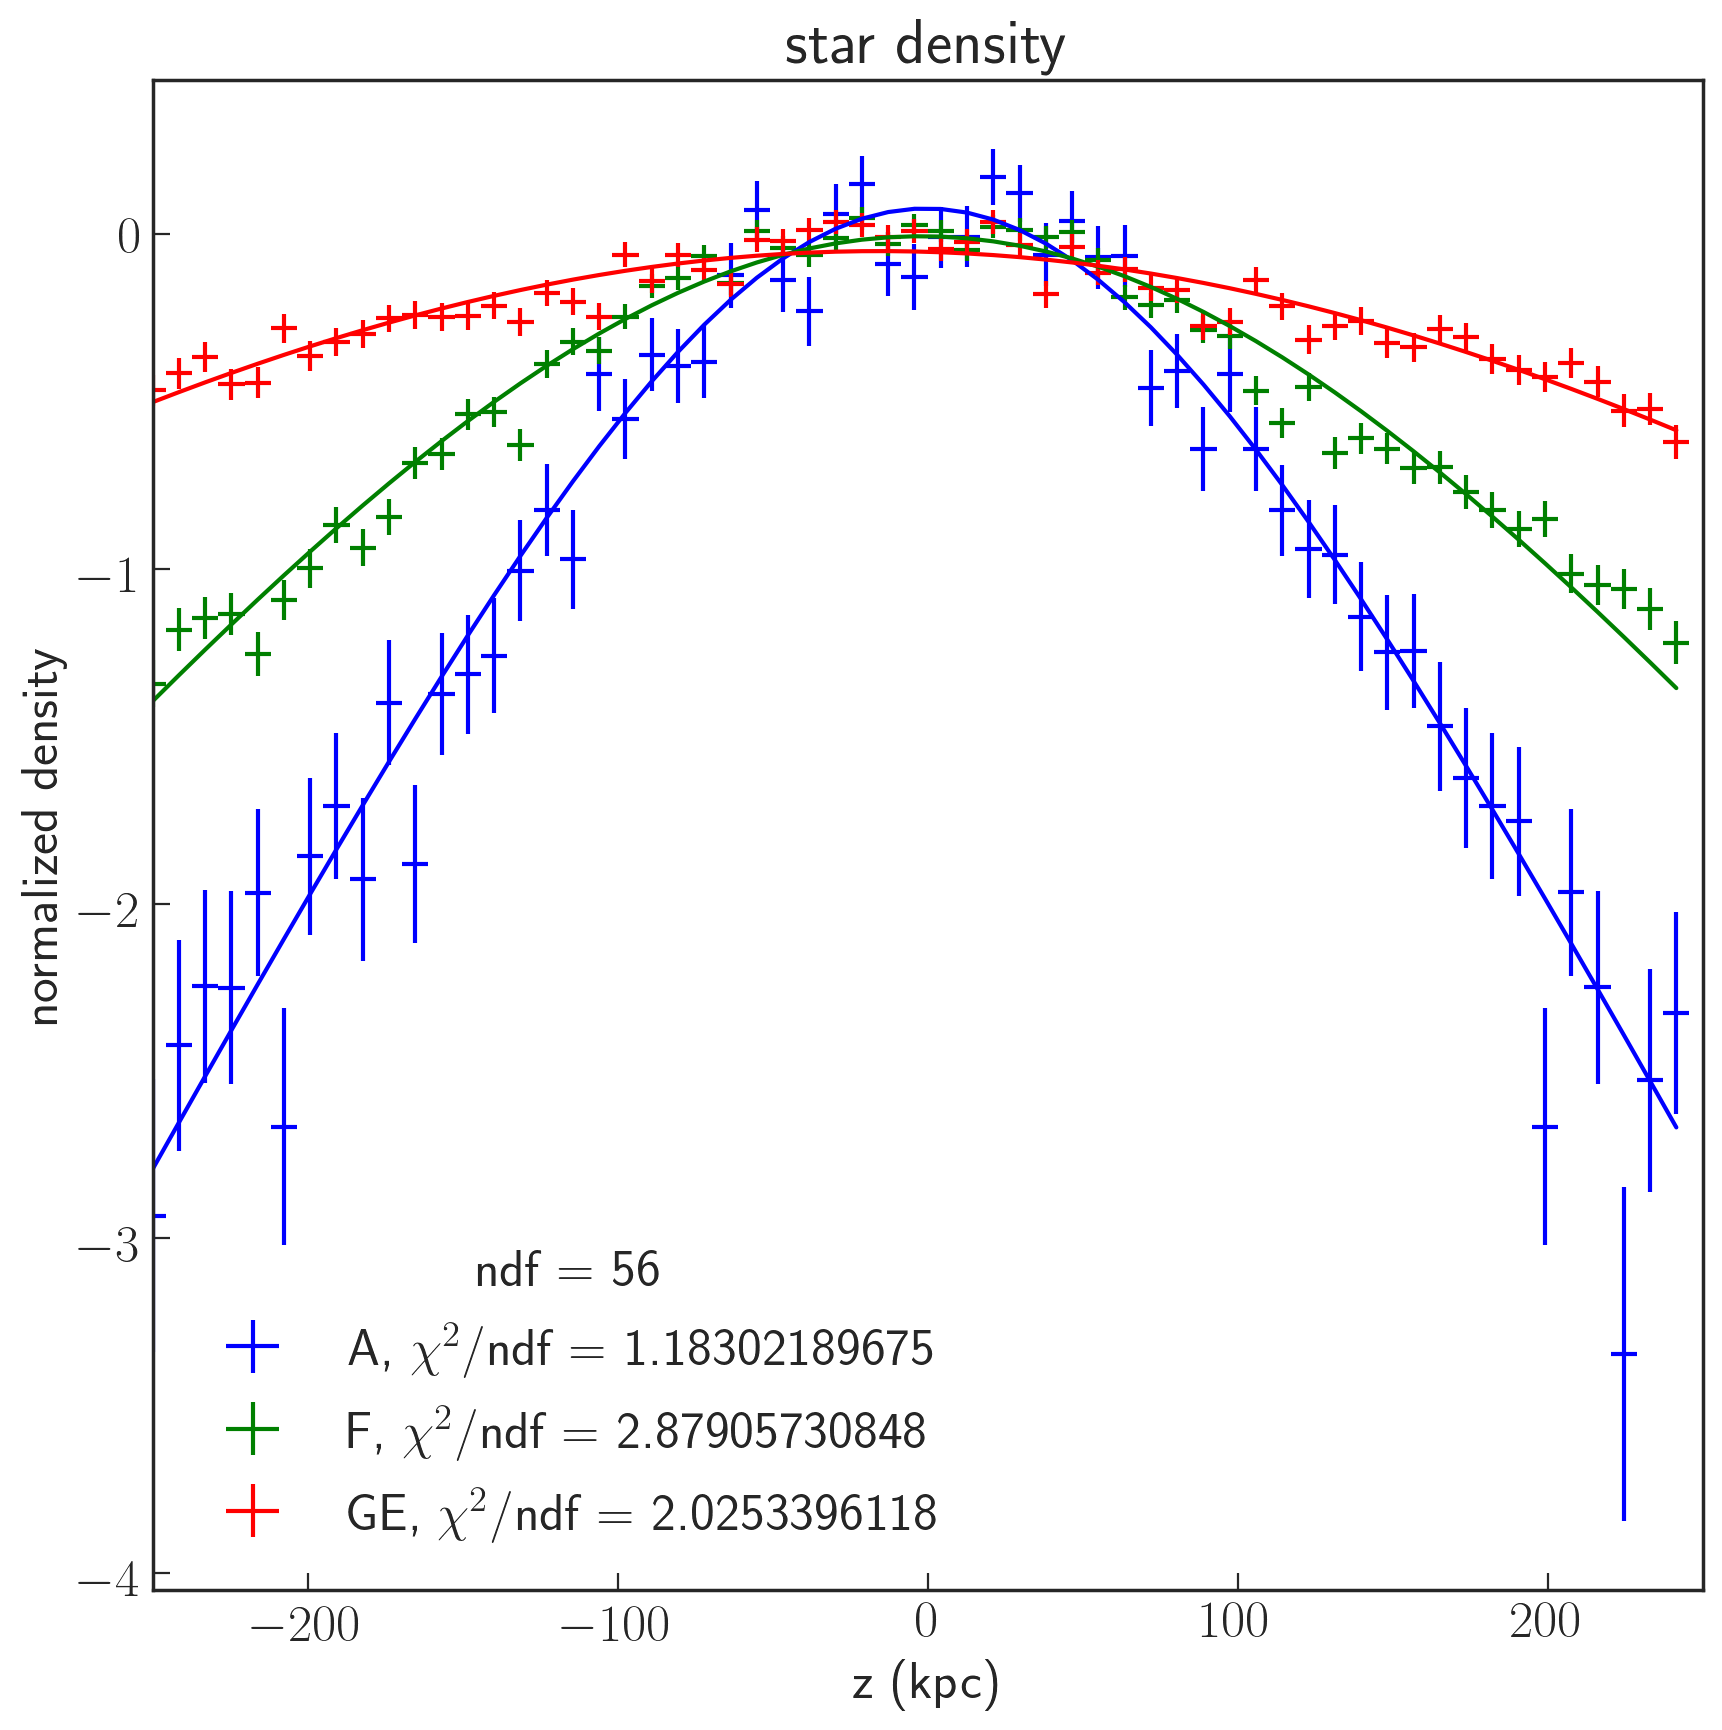

In [14]:
plt.figure(figsize=(10,10))
colors=['blue','green','red','pink','magenta','black']

dust_err = 0.03
star_Cats=['A','F','GE']
for i, star_Cat in enumerate(star_Cats):
   print("Star cat: " + star_Cat)
   stars_plt_evfs = evfs_list[i]
   stars_plt_evfs_err = evfs_err_list[i]

   plt_norm = np.mean([stars_plt_evfs[int(len(stars_plt_evfs)/2)+k] for k in range(-3,3)])
   stars_plt_evfs_normed = stars_plt_evfs/plt_norm
   stars_plt_evfs_err_normed = np.sqrt((stars_plt_evfs_err/plt_norm)**2 + ((dust_err*stars_plt_evfs/plt_norm)/plt_norm)**2)

   stars_plt_evfs_err_normed = stars_plt_evfs_err_normed /stars_plt_evfs_normed
   stars_plt_evfs_normed = np.log(stars_plt_evfs_normed)
    
   sechsq = lambda x, h, k, x0: np.log((0.25*k)*(np.cosh(x0+x/(2.*h)))**(-2))
   h_fit, h_fit_err = optimize.curve_fit( sechsq, bins_plt, stars_plt_evfs_normed ,  sigma=stars_plt_evfs_err_normed)
   print("Best-fit velocity h = ", h_fit[0], " +/- ", h_fit_err[0,0])
   print("Best-fit z_sun = ", 2*h_fit[0]*h_fit[2], " +/- ", 2*h_fit[0]*h_fit_err[2,2])
    
   chi_sq = np.sum((sechsq(bins_plt, h_fit[0], h_fit[1], h_fit[2]) -  stars_plt_evfs_normed)**2/stars_plt_evfs_err_normed**2)
   ndf = len(bins_plt)-3; print("(chi-square, ndf) =", (chi_sq, ndf))
    
   plt.errorbar(bins_plt, stars_plt_evfs_normed, yerr=stars_plt_evfs_err_normed, xerr=1000*dz_plt/2, capthick=2,
                label=(star_Cat + ", $\chi^2$/ndf =  " + str(chi_sq/float(ndf))), color=colors[i],ls='none')
   plt.plot( bins_plt, sechsq(bins_plt, h_fit[0], h_fit[1], h_fit[2]), color=colors[i])
   print("chi-square per ndf = " + str(chi_sq/float(ndf)))
   
   binfilename = star_Cat+"_bin_r_"+str(int(1000*r_cyl_cut))+"_zbin_20.txt"
   bindata = np.transpose([bins_plt, stars_plt_evfs_normed, stars_plt_evfs_err_normed])
   np.savetxt(binfilename, bindata, delimiter=',',header="z_Bin_center, z_Bin_count, z_Bin_error", fmt='%10.5f')
   print("saved file to : " + binfilename)
    
plt.title("star density"); plt.ylabel("normalized density"); plt.xlabel("z (kpc)");
plt.xlim(-250,250);
plt.legend(title='ndf = '+str(ndf));
plt.show()